# Inventory Monitoring at Distribution Centers
## Udacity AWS Machine Learning Engineer - Capstone Project

This is a Deep learning project done as part of Udacity's capstone project of AWS Machine Learning Engineer Nanodegree Program. 

Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects. Occasionally, items are misplaced while being handled, so the contents of some bin images may not match the recorded inventory of that bin.

Now, this project is about building a model that can count the number of objects in each bin. A system like this can be used to track inventory and make sure that delivery consignments have the correct number of items

The solution here is to use AWS SageMaker and good machine-learning engineering practices to fetch data from Amazon Bin Image Dataset, preprocess it, and then train a pre-trained model that can classify the image based on the number of objects in the bin

In [ ]:
# Install packages
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm ipywidgets bokeh

In [ ]:
! apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

In [ ]:
! pip install easydev colormap colorgram.py extcolors

In [6]:
# Importing packages
%matplotlib inline

import os
import json
import boto3
import sagemaker

import torch
import torch.nn as nn
import torch.nn.functional as F
import IPython

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2

from PIL import Image
from tqdm import tqdm
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split


## Data Preparation
Running this cell below will download the data.

The cell below creates a three folders called `dataset`, downloads training, validation, and testing data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them.

In [11]:
def download_images(files_list, data_path):
    s3_client = boto3.client('s3')
    data_path = os.path.join('dataset', data_path)

    for k, v in files_list.items():
        print(f"Downloading Images with {k} objects to {data_path}")
        directory=os.path.join(data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

def download_and_arrange_data():
    with open('misc/file_list.json', 'r') as f:
        d=json.load(f)

    #spliting data into 65% for traininig, 20% for validationa and 15% for testing
    train = {}
    test = {}
    validation = {}
    for k, v in d.items():
        train[k], test[k] = train_test_split(d[k], test_size=0.35, random_state=0)
        test[k], validation[k] = train_test_split(test[k], test_size=0.60, random_state=0)

    download_images(train, 'train')
    download_images(test, 'test')
    download_images(validation, 'valid')

download_and_arrange_data()

  0%|          | 2/798 [00:00<00:59, 13.27it/s]

  0%|          | 1/1494 [00:00<03:12,  7.76it/s]

  0%|          | 2/1732 [00:00<02:26, 11.81it/s]

  0%|          | 1/1542 [00:00<03:01,  8.51it/s]

  0%|          | 1/1218 [00:00<02:29,  8.16it/s]

  1%|          | 1/172 [00:00<00:21,  7.78it/s]

  1%|          | 2/322 [00:00<00:30, 10.66it/s]

  1%|          | 2/373 [00:00<00:33, 10.96it/s]

  0%|          | 1/332 [00:00<00:49,  6.69it/s]

  0%|          | 1/262 [00:00<00:39,  6.64it/s]

  0%|          | 1/258 [00:00<00:39,  6.54it/s]

  0%|          | 1/483 [00:00<00:57,  8.41it/s]

  0%|          | 2/561 [00:00<00:45, 12.41it/s]

  0%|          | 2/499 [00:00<00:38, 12.78it/s]

  0%|          | 1/395 [00:00<00:48,  8.15it/s]

100%|██████████| 395/395 [00:39<00:00,  9.93it/s]


## Dataset

Our dataset is very big considering 500,000 images, here in our project we going to consider only a small chunk of this dataset, about 10441 images split between training, validation and testing, and to evaluate the model performance than launch a big training job of all the dataset, this approach will help us reduce cost and time when developing new machine learning models.

In [12]:
# Perform data cleaning or data preprocessing
train_df = 'dataset'
 
folders =  os.listdir(train_df)
 
bin_images = pd.DataFrame()
for folder in folders:
    allCategories =  os.listdir(os.path.join(train_df, folder))
    for category in allCategories:
        allFiles = os.listdir(os.path.join(train_df, folder, category))
        files = []
        for file in allFiles:
            bin_images = bin_images.append({'image_name': os.path.join(train_df, folder,category,file),
                                            'category': category,
                                            'type' : folder },
                                            ignore_index = True) if ('.jpg' in file) else None


In [13]:
bin_images.head()

category                 image_name  type
0        4  dataset/test/4/102257.jpg  test
1        4  dataset/test/4/103706.jpg  test
2        4   dataset/test/4/05561.jpg  test
3        4   dataset/test/4/01169.jpg  test
4        4  dataset/test/4/105128.jpg  test

In [14]:
bin_images.describe()

category                 image_name   type
count     10441                      10441  10441
unique        5                      10441      3
top           3  dataset/train/2/06072.jpg  train
freq       2666                          1   6784

In [15]:
bin_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    10441 non-null  object
 1   image_name  10441 non-null  object
 2   type        10441 non-null  object
dtypes: object(3)
memory usage: 244.8+ KB


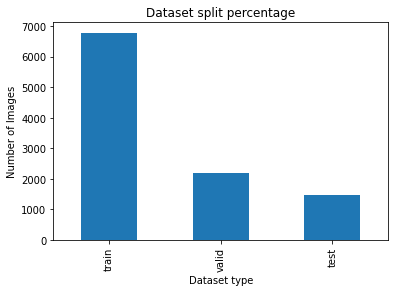

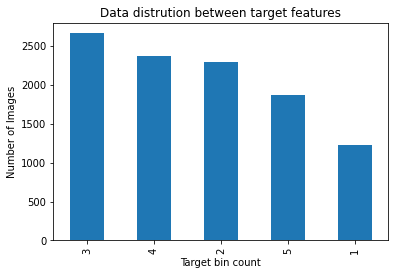

In [16]:
type_plot = bin_images['type'].value_counts().plot.bar()
plt.title('Dataset split percentage')
plt.xlabel('Dataset type')
plt.ylabel('Number of Images')
plt.savefig('results/dataset_split_percentage.png')
plt.figure()
category_plot = bin_images['category'].value_counts().plot.bar()
plt.title('Data distrution between target features')
plt.xlabel('Target bin count')
plt.ylabel('Number of Images')
plt.savefig('results/data_distrution_between_target_features.png')

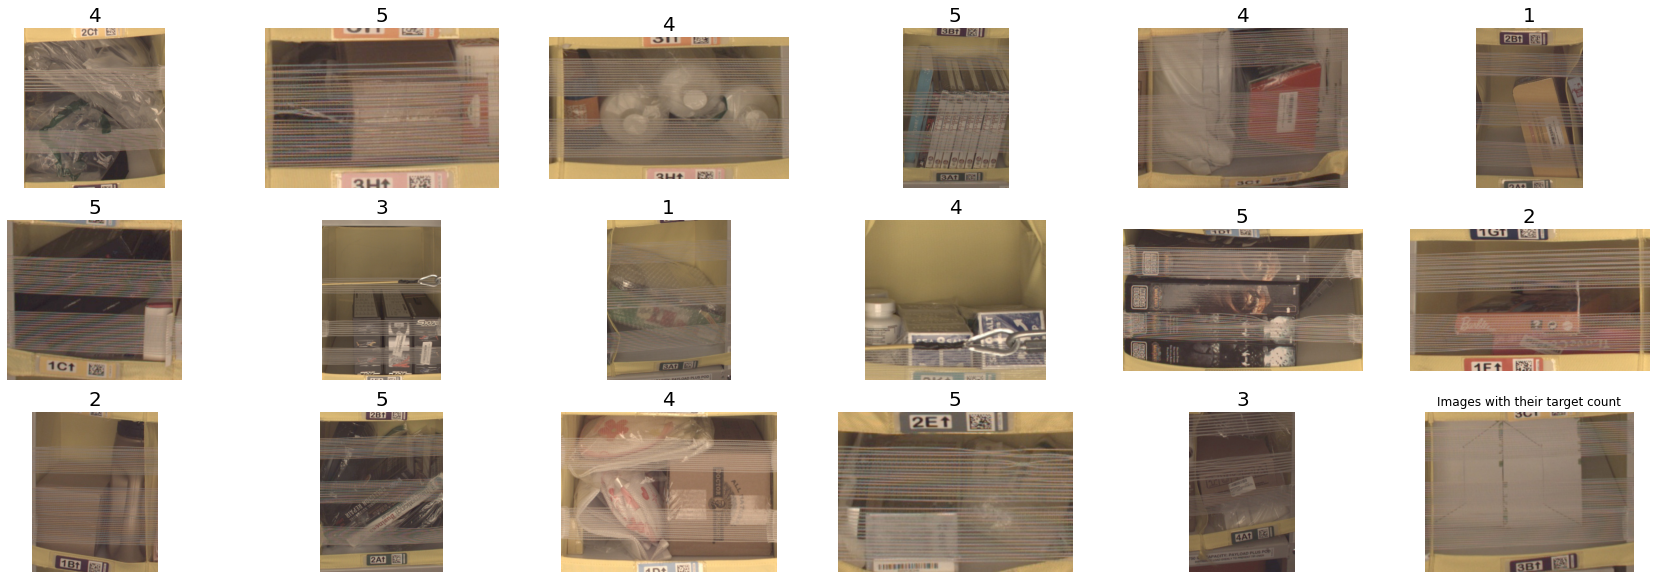

In [17]:
fig = plt.figure(figsize=(30, 10))
rows, columns = 3, 6

sampled_list = random.sample(bin_images.values.tolist(), 18)

for index, sample in enumerate(sampled_list):
    fig.add_subplot(rows, columns, index+1)
    #print(sample[0])
    plt.imshow(Image.open(sample[1]))
    plt.axis('off')
    plt.title(sample[0], fontsize=20)
    
plt.title('Images with their target count')
plt.savefig('results/images_with_their_target_count.png')

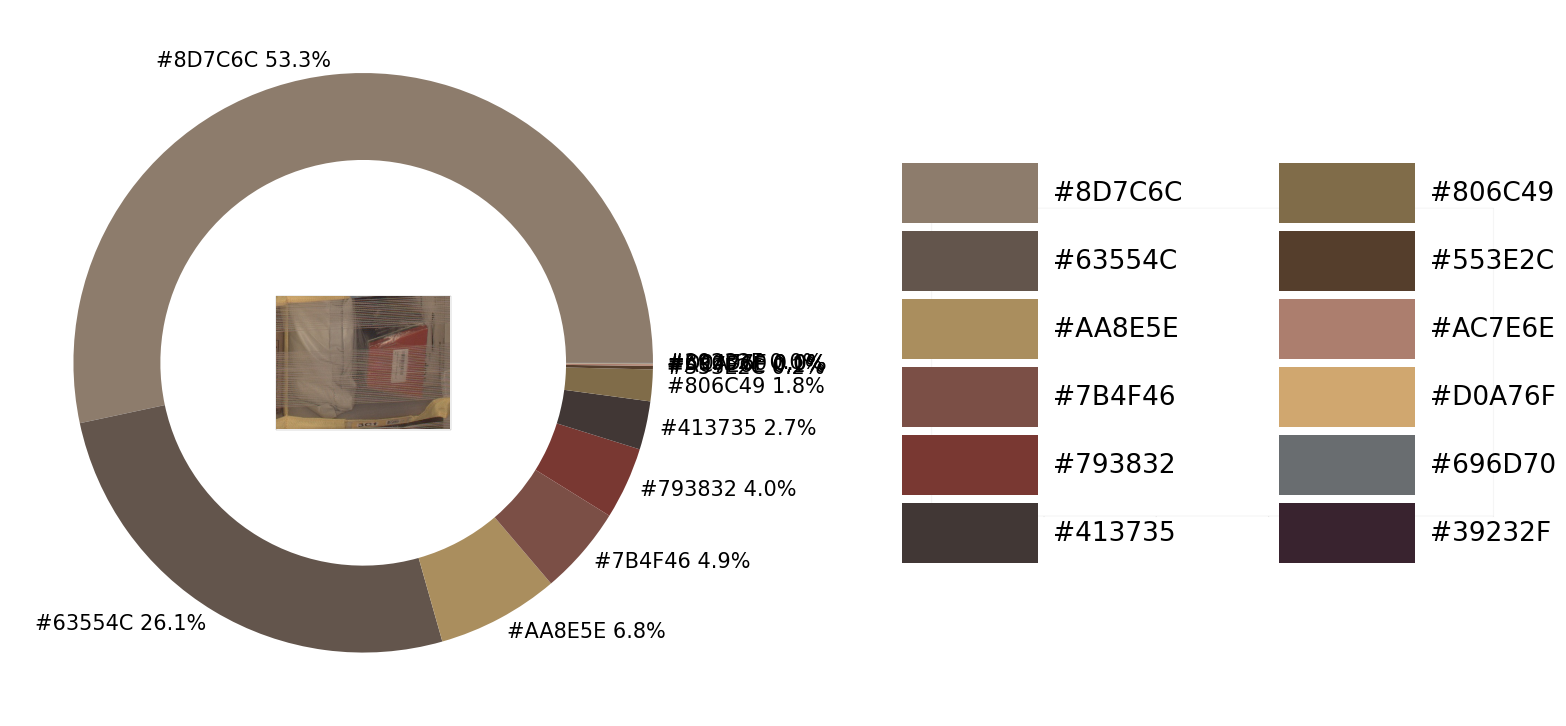

In [26]:
from utils import exact_color
exact_color(sampled_list[4][1], 900, 12, 2.5)

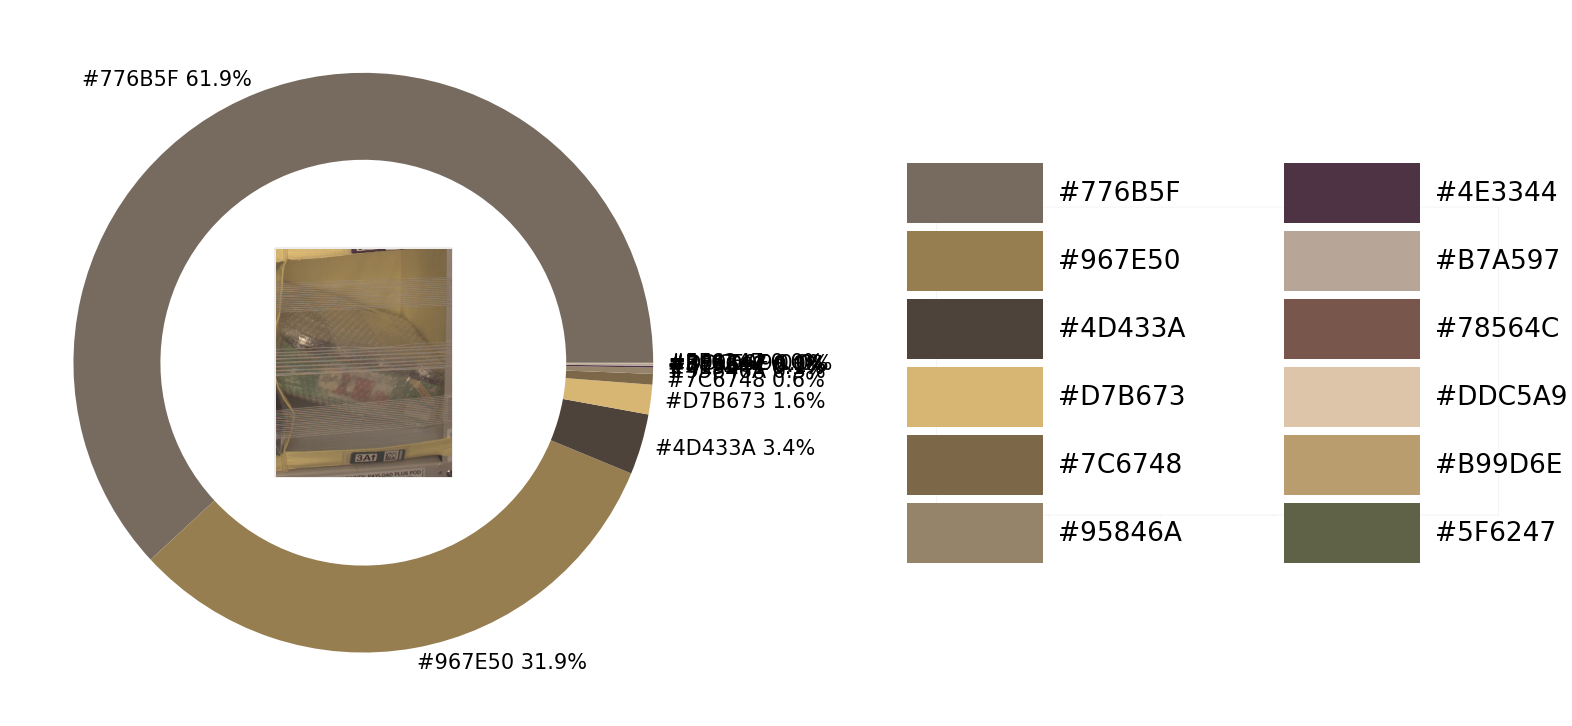

In [27]:
exact_color(sampled_list[8][1], 900, 12, 2.5)

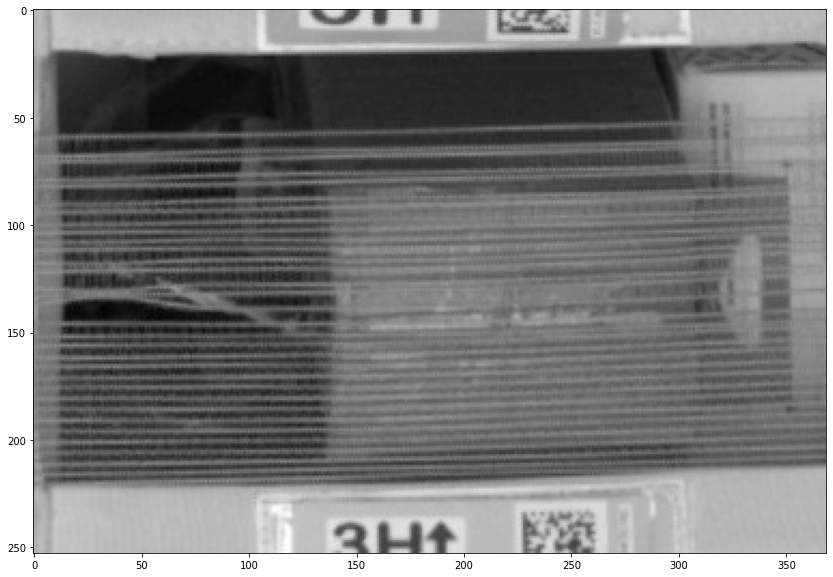

In [28]:
# load color image 
bgr_img = cv2.imread(sampled_list[1][1])
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255
plt.figure(figsize=(15, 10))
# plot image
plt.imshow(gray_img, cmap='gray')
plt.savefig('results/gray_img.png')
plt.show()

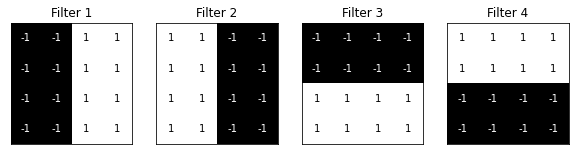

In [29]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])
# visualize all four filters
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

[2023-04-04 21:19:13.119 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:33 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-04 21:19:13.231 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:33 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


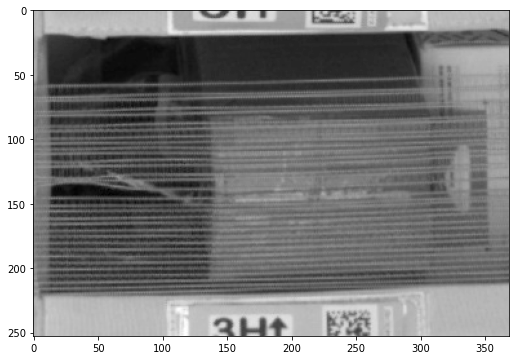

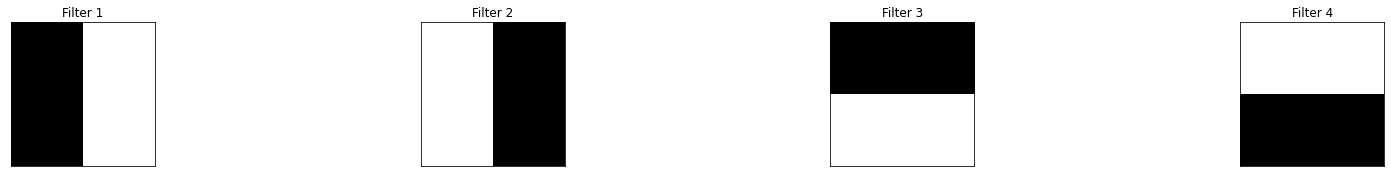

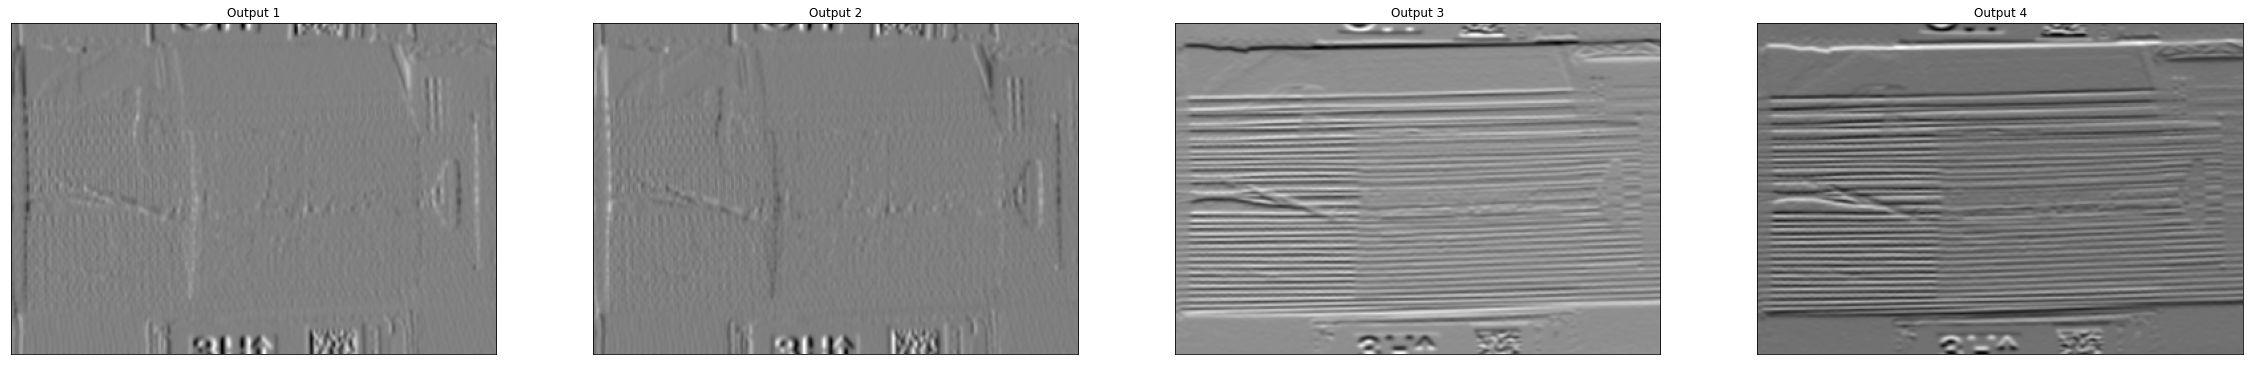

In [31]:
from utils import Net, viz_layer

# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)
plt.figure(figsize=(10, 6))
plt.imshow(gray_img, cmap='gray')

fig = plt.figure(figsize=(15, 10))
# visualize all filters
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get the convolutional layer (pre and post activation)
conv_layer, activated_layer = model(gray_img_tensor)

# visualize the output of a conv layer
viz_layer(conv_layer)


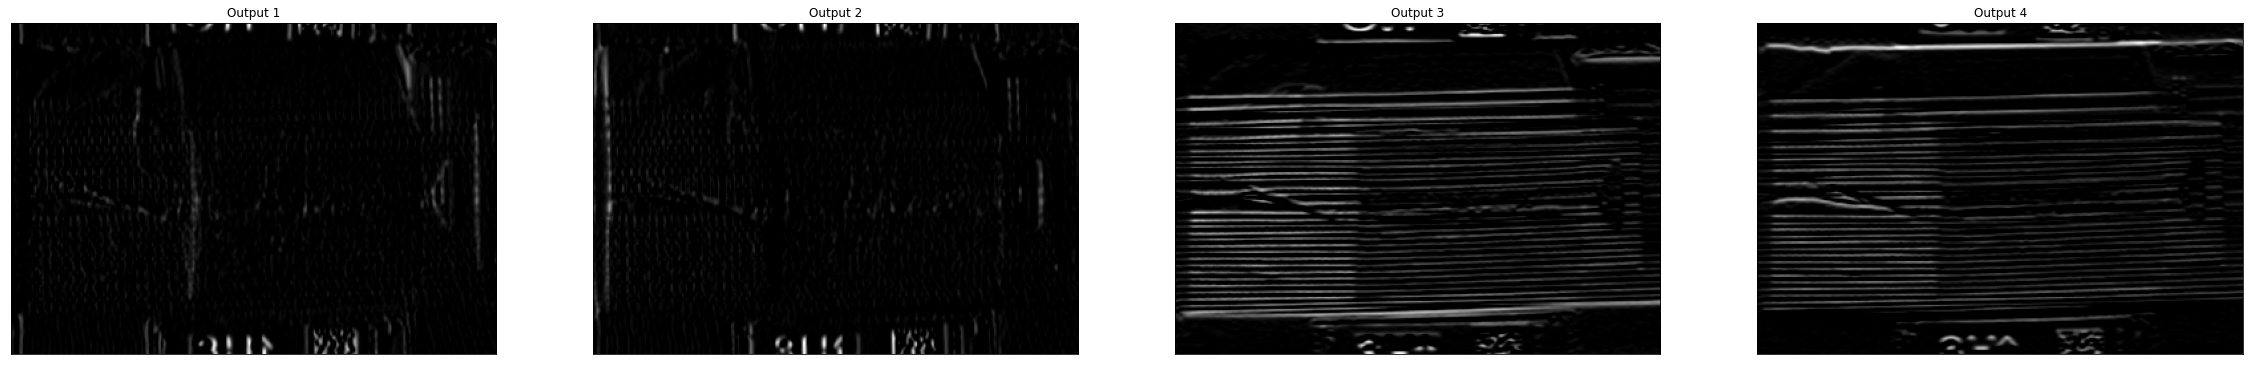

In [32]:
# after a ReLu is applied
# visualize the output of an activated conv layer
viz_layer(activated_layer)

## Data Insights

1- Looking at the charts above we are seeing that images count are not uniform and that could lead to our model to be biased because when training our model will see more images from one caterory count than the others, example the "3" category have double the images compared to the "1" category

2- Again we slipted our data with 66% training, 22% validation and 12% testing, and i think this is a good balance for our model.  

3- Now when seeing random images from our dataset, I've noticed that the images are a bit dificult to distinguich items count because:
- the image colors and saturation
- the presence of the packaging tape that cover some of the details
- items are rapped in same packaging papers
- position and angle of the items (too close to each other, they can be seen as one item)

4- Some data cleaning and preparation is required. above we used a method of extracing dominant color from the image, and we noticed that the most dominant color is the color of the packaging this will not help our model train better because we need only useful information to pass to our model, (this method was taken from a publish from this URL https://towardsdatascience.com/image-color-extraction-with-python-in-4-steps-8d9370d9216e)

5- visulizing our image after they passed throught some CNN filters, we see that some filters make the packaging tape dominant above items and that will  make training worse, other filter remove the packaging tape but make the image have information to pass to our model. (this method was taken from a udacity course materials from this URL https://github.com/udacity/machine-learning/blob/master/projects/practice_projects/cnn/conv-visualization/conv_visualization.ipynb)

Finally, since this dataset can be passed to our model, I've decided to let it raw and upload it directly to AWS S3 Bucket.

## Uploading data to AWS S3

In [ ]:
# Upload the data to AWS S3
!aws s3 cp 'dataset' s3://udacity-capstone-project-2023/ --recursive

In [27]:
!aws s3 cp 'models' s3://udacity-capstone-project-2023/models --recursive

upload: models/resnet34_best.pth.tar to s3://udacity-capstone-project-2023/models/resnet34_best.pth.tar


## Hyperparameter Tuning

First, we will start by finding the best hyperparameters by launching a hyperparameter tuning job with our pretrained model. the choice of hyperparameters ranges is arbitrary and the two most imporant parameters are the learning rate and the batch-size.

- The learning rate: is very important in speeding the learning process, as a wrong / to small learning rate can lead to overfitting, but a too large one might create non-optimal results as well.

- The batch size: is also very important as it controls the accuracy of the estimate of the error gradient when training neural networks.

here we will use the `hpo.py` script to to do hyperparameter tuning, and we gonna use a `ml.g4dn.xlarge` for speed up the work sine we have only one available.

In [15]:
role = sagemaker.get_execution_role()

In [16]:
# Declare Hyperparameter ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(10,40)
}

objective_metric_name = "Average Test loss"
objective_type = "Minimize"
#metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]
metric_definitions = [{"Name": "Average Test loss", "Regex": "Average Test loss: ([0-9\\.]+)"}]



In [42]:
# Create the HyperparameterTuner estimator
estimator = PyTorch(
    entry_point="code/hpo.py",
    base_job_name='inventory_monitoring_hpo',
    role=role,
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py36',
    output_path = "s3://udacity-capstone-project-2023/hpo-output/"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  
    objective_type=objective_type
)

In [63]:
os.environ['SM_CHANNEL_TRAINING']='s3://udacity-capstone-project-2023/'
os.environ['SM_MODEL_DIR']='s3://udacity-capstone-project-2023/models/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacity-capstone-project-2023/output/'

In [22]:
# Fit the estimator
tuner.fit({"training": "s3://udacity-capstone-project-2023/"})

..............................................................................................................................................................................!


## Model Training with the best hyperparameters


In [23]:
# Find the best hyperparameters
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate'], \
                   "epochs": best_estimator.hyperparameters()['epochs']}

hyperparameters


2023-04-02 17:02:39 Starting - Preparing the instances for training
2023-04-02 17:02:39 Downloading - Downloading input data
2023-04-02 17:02:39 Training - Training image download completed. Training in progress.
2023-04-02 17:02:39 Uploading - Uploading generated training model
2023-04-02 17:02:39 Completed - Resource reused by training job: pytorch-training-230402-1656-002-2daf9942


{'batch_size': 128, 'learning_rate': '0.06246976097402943', 'epochs': '11'}

In [21]:
hyperparameters = {'batch_size': 128, 'learning_rate': '0.06246976097402943', 'epochs': '25'}

hyperparameters

{'batch_size': 128, 'learning_rate': '0.06246976097402943', 'epochs': '25'}

In [28]:
#Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters = {"train.save_interval": "10", "eval.save_interval": "5"},
    collection_configs = [CollectionConfig(name = "CrossEntropyLoss_output_0",
                                           parameters = {
                                               "include_regex": "CrossEntropyLoss_output_0",
                                               "train.save_interval": "10",
                                               "eval.save_interval": "1"})]
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

## Single-Instance Training

In [29]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='code/train.py',
    base_job_name='inventory-monitoring',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    output_path = "s3://udacity-capstone-project-2023/output-best/",
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [30]:
os.environ['SM_CHANNEL_TRAINING']='s3://udacity-capstone-project-2023/'
os.environ['SM_MODEL_DIR']='s3://udacity-capstone-project-2023/models/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacity-capstone-project-2023/output/'

estimator.fit({"training": "s3://udacity-capstone-project-2023/"})

2023-04-06 00:01:29 Starting - Starting the training job...
2023-04-06 00:01:58 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-04-06 00:02:58 Downloading - Downloading input data...
2023-04-06 00:03:19 Training - Downloading the training image.....................
2023-04-06 00:07:00 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-06 00:07:03,398 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-06 00:07:03,430 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-06 00:07:03,433 sagemaker_pytorch_container.training INFO     Invoking user training scr

In [7]:
# attaching the estimator to a previous training job 
TrainingJobName='inventory-monitoring-2023-04-06-00-01-29-320'
estimator = sagemaker.estimator.Estimator.attach(TrainingJobName)
estimator.hyperparameters()


2023-04-06 00:23:25 Starting - Preparing the instances for training
2023-04-06 00:23:25 Downloading - Downloading input data
2023-04-06 00:23:25 Training - Training image download completed. Training in progress.
2023-04-06 00:23:25 Uploading - Uploading generated training model
2023-04-06 00:23:25 Completed - Training job completed


{'batch_size': '128',
 'epochs': '"25"',
 'learning_rate': '"0.06246976097402943"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"inventory-monitoring-2023-04-06-00-01-29-320"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://udacity-capstone-project-2023/inventory-monitoring-2023-04-06-00-01-29-320/source/sourcedir.tar.gz"'}

## Checking Training Performance
### Model Profiling and Debugging

In [98]:
session = boto3.session.Session()
region = session.region_name

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Training jobname: {job_name}")
print(f"Region: {region}")

Training jobname: inventory-monitoring-2023-04-06-00-01-29-320
Region: us-east-1


In [99]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial("s3://udacity-capstone-project-2023/output-best/inventory-monitoring-2023-04-06-00-01-29-320/debug-output/")
#trial = create_trial(estimator.latest_job_debugger_artifacts_path())
#trial.tensor_names()

[2023-04-07 23:12:55.454 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:64 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-07 23:12:55.489 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:64 INFO s3_trial.py:42] Loading trial  at path s3://udacity-capstone-project-2023/output-best/inventory-monitoring-2023-04-06-00-01-29-320/debug-output/


In [41]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

30

In [42]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

462

In [47]:
# Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.savefig('results/CrossEntropy_Loss_during_training_and_validation.png')
    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


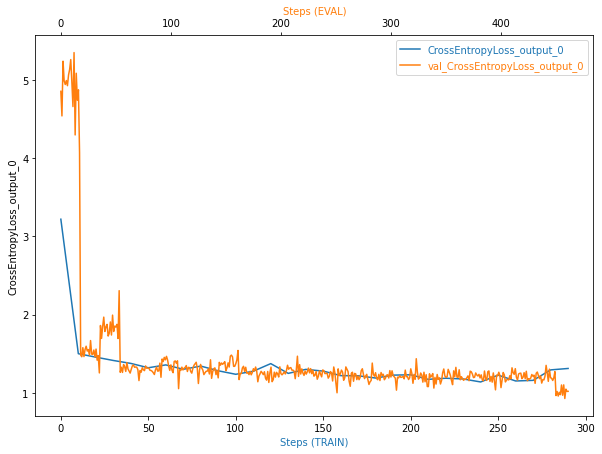

In [48]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [45]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://udacity-capstone-project-2023/output-best/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://udacity-capstone-project-2023/output-best/inventory-monitoring-2023-04-06-00-01-29-320/profiler-output


Profiler data from system is available


In [46]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-04-06 00:29:16.882 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:34 INFO metrics_reader_base.py:134] Getting 21 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [100]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://udacity-capstone-project-2023/output-best/inventory-monitoring-2023-04-06-00-01-29-320/rule-output
2023-04-06 00:22:53     416803 output-best/inventory-monitoring-2023-04-06-00-01-29-320/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-06 00:22:53     271471 output-best/inventory-monitoring-2023-04-06-00-01-29-320/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-06 00:22:48        192 output-best/inventory-monitoring-2023-04-06-00-01-29-320/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-06 00:22:48      33326 output-best/inventory-monitoring-2023-04-06-00-01-29-320/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-06 00:22:48       2063 output-best/inventory-monitoring-2023-04-06-00-01-29-320/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-06 00:22:48        332 output-best/inventory-monitor

## Model Deploying and Querying

In [9]:
model_location=estimator.model_data

In [10]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [12]:
role = sagemaker.get_execution_role()

pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='code/inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [13]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

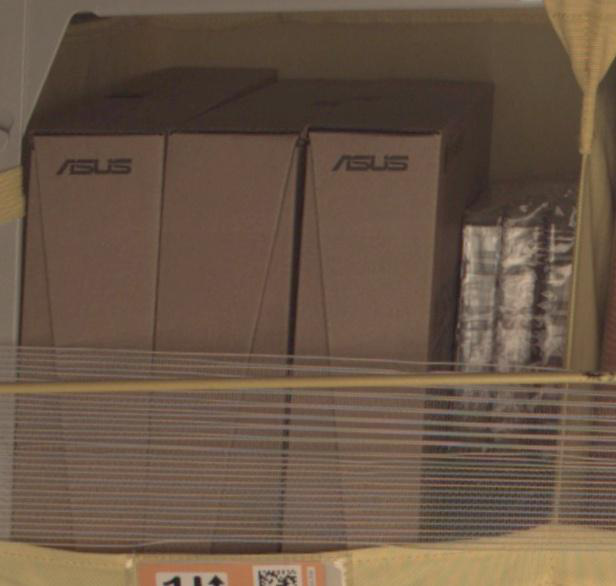

In [14]:
from PIL import Image
import io

def image_to_byte_array(image:Image):
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format=image.format)
    imgByteArr = imgByteArr.getvalue()
    return imgByteArr

img = Image.open("dataset/test/4/00010.jpg", mode='r')
img_bytes = image_to_byte_array(img)
Image.open(io.BytesIO(img_bytes))

In [15]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [16]:
response

[[-7.966815948486328,
  -4.312801361083984,
  2.588212490081787,
  4.92999267578125,
  6.17242956161499,
  -1.381866216659546]]

In [17]:
index = np.argmax(response, 1)[0]

In [18]:
print(index)

4


In [19]:
img = Image.open("dataset/test/5/00132.jpg", mode='r')
img_bytes = image_to_byte_array(img)
Image.open(io.BytesIO(img_bytes))
response2=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [20]:
response2

[[2.5474486351013184,
  1.9740455150604248,
  0.8217211961746216,
  0.3288322389125824,
  -0.349445641040802,
  -5.314144611358643]]

In [21]:
index = np.argmax(response2, 1)[0]
print(index)

0


In [77]:
test_folder = 'dataset/test'
 
Categories =  os.listdir(test_folder)
 
test_images = pd.DataFrame()
for category in Categories:
    allFiles = os.listdir(os.path.join(test_folder, category))
    files = []
    for file in allFiles:
        test_images = test_images.append({'image_name': os.path.join(os.path.join(test_folder, category ,file)),
                                        'category': int(category)},
                                        ignore_index = True) if ('.jpg' in file) else None
test_images = test_images.sample(frac = 1)

In [78]:
test_images.describe()

category
count  1461.000000
mean      3.130048
std       1.272817
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000

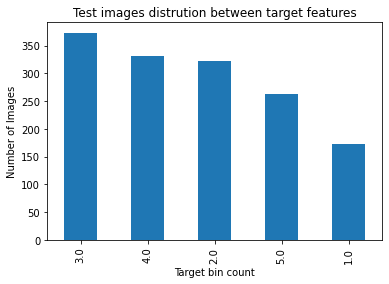

In [97]:
category_plot = test_images['category'].value_counts().plot.bar()
plt.title('Test images distrution between target features')
plt.xlabel('Target bin count')
plt.ylabel('Number of Images')
plt.savefig('results/test_images_distrution_between_target_features.png')

In [57]:
def predict_image(image_path, label):
    img = Image.open(image_path, mode='r')
    img_bytes = image_to_byte_array(img)
    response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
    result = int(np.argmax(response, 1)[0])
    return result

In [26]:
test_results = pd.DataFrame()

for index, row in test_images.iterrows():
    result = predict_image(row[1], row[0])
    test_results = test_results.append({'image_name': row[1],
                                        'category'  : int(row[0]),
                                        'prediction': result },
                                        ignore_index = True)


In [27]:
test_results.head()

category                 image_name  prediction
0       3.0   dataset/test/3/01010.jpg         2.0
1       2.0   dataset/test/2/10461.jpg         1.0
2       1.0  dataset/test/1/104130.jpg         1.0
3       4.0   dataset/test/4/05239.jpg         2.0
4       2.0  dataset/test/2/102842.jpg         1.0

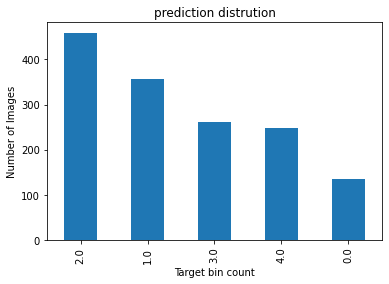

In [96]:
prediction_plot = test_results['prediction'].value_counts().plot.bar()
plt.title('prediction distrution')
plt.xlabel('Target bin count')
plt.ylabel('Number of Images')
plt.savefig('results/prediction_distrution.png')

In [81]:
category = test_images['category'].value_counts().sort_index()
category = category.reindex([0,1,2,3,4,5], fill_value=0)
print(category)
prediction = test_results['prediction'].value_counts().sort_index()
prediction = prediction.reindex([0,1,2,3,4,5], fill_value=0)
print(prediction)

0      0
1    172
2    322
3    373
4    332
5    262
Name: category, dtype: int64
0    134
1    357
2    459
3    262
4    249
5      0
Name: prediction, dtype: int64


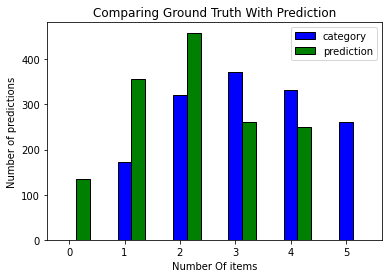

In [84]:
import numpy as np
import matplotlib.pyplot as plt

r= np.arange(len(category))
r2= np.arange(len(prediction))

width = 0.25

plt.bar(r, category, color = 'b',
        width = 0.25, edgecolor = 'black',
        label='category')

plt.bar(r2 + width, prediction, color = 'g',
        width = 0.25, edgecolor = 'black',
        label='prediction')
plt.xlabel("Number Of items")
plt.ylabel("Number of predictions")
plt.title("Comparing Ground Truth With Prediction")
  
plt.legend()
plt.savefig('results/Comparing_Ground_Truth_With_Prediction.png')
plt.show()

#### Calculating Accuracy

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy_score(test_results['category'], test_results['prediction'])

0.20191649555099248

In [94]:
print(classification_report(test_results['category'], test_results['prediction'], target_names=['0','1','2','3','4','5'], digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.1345    0.2791    0.1815       172
           2     0.2157    0.3075    0.2535       322
           3     0.2595    0.1823    0.2142       373
           4     0.3213    0.2410    0.2754       332
           5     0.0000    0.0000    0.0000       262

    accuracy                         0.2019      1461
   macro avg     0.1552    0.1683    0.1541      1461
weighted avg     0.2026    0.2019    0.1945      1461



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1

In [95]:
# here once all work is done, we gonna shutdown/delete the endpoint 
predictor.delete_endpoint()

### Multi-Instance Training

In [ ]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='code/train.py',
    base_job_name='inventory-monitoring',
    role=role,
    instance_count=5,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    output_path = "s3://udacity-capstone-project-2023/output-best/",
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [ ]:
os.environ['SM_CHANNEL_TRAINING']='s3://udacity-capstone-project-2023/'
os.environ['SM_MODEL_DIR']='s3://udacity-capstone-project-2023/models/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacity-capstone-project-2023/output/'

estimator.fit({"training": "s3://udacity-capstone-project-2023/"})